In [1]:
# importing, reading, and combining data
import numpy as np 
import pandas as pd

# sklearn for classifiers and testing
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# data balancing
import collections
from imblearn.over_sampling import SMOTE

# figures and visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# misc
import time

# maps
import geopandas as gpd

In [2]:
# get source data
source_table = "E:\Git_repos\Australian_rain\weatherAUS.csv"
shapefile = "E:\Git_repos\Australian_rain\states\STE_2016_AUST.shp"
source_df = pd.read_csv(source_table)

# explore dataset
source_df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


In [3]:
# make territory dictionary (done manually)
territory_dict = {"New South Wales": ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree', 
                          'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond', 
                          'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong'],
                  "Victoria": ['Ballarat', 'Bendigo', 'Dartmoor', 'Sale', 'MelbourneAirport', 'Melbourne','Mildura',
                          'Nhil', 'Portland', 'Watsonia'],
                  "Queensland": ['Brisbane', 'Cairns', 'GoldCoast', 'Townsville'],
                  "South Australia": ['Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera'],
                  "Western Australia": ['Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums'
                          'Walpole'],
                  "Tasmania": ['Hobart', 'Launceston'],
                  "Northern Territories": ['AliceSprings', 'Darwin', 'Katherine', 'Uluru'],
                  "Australian Capital Territory": ['Canberra', 'Tuggeranong', 'Mount Ginini'], }

# replace categorical values
cardinal_dict = {"N": 0, "NNE": 1, "NE": 2, "ENE": 3,
                 "E": 4, "ESE": 5, "SE": 6, "SSE": 7,
                 "S": 8, "SSW": 9, "SW": 10, "WSW": 11,
                 "W": 12, "WNW": 13, "NW": 14, "NNW": 15}
categorical_replacements = {"WindGustDir": cardinal_dict,
                            "WindDir9am": cardinal_dict,
                            "WindDir3pm": cardinal_dict,
                            "RainToday": {"No":0, "Yes": 1},
                            "RainTomorrow": {"No":0, "Yes": 1}}

In [4]:
# convert the categorical data
source_df = source_df.replace(categorical_replacements)

# replace Nan
source_df = source_df.fillna(0)

# check the header
source_df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,0.0,0.0,12.0,44.0,12.0,...,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0.0,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,0.0,0.0,13.0,44.0,15.0,...,44.0,25.0,1010.6,1007.8,0.0,0.0,17.2,24.3,0.0,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,0.0,0.0,11.0,46.0,12.0,...,38.0,30.0,1007.6,1008.7,0.0,2.0,21.0,23.2,0.0,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,0.0,0.0,2.0,24.0,6.0,...,45.0,16.0,1017.6,1012.8,0.0,0.0,18.1,26.5,0.0,0.0
4,2008-12-05,Albury,17.5,32.3,1.0,0.0,0.0,12.0,41.0,3.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0
5,2008-12-06,Albury,14.6,29.7,0.2,0.0,0.0,13.0,56.0,12.0,...,55.0,23.0,1009.2,1005.4,0.0,0.0,20.6,28.9,0.0,0.0
6,2008-12-07,Albury,14.3,25.0,0.0,0.0,0.0,12.0,50.0,10.0,...,49.0,19.0,1009.6,1008.2,1.0,0.0,18.1,24.6,0.0,0.0
7,2008-12-08,Albury,7.7,26.7,0.0,0.0,0.0,12.0,35.0,7.0,...,48.0,19.0,1013.4,1010.1,0.0,0.0,16.3,25.5,0.0,0.0
8,2008-12-09,Albury,9.7,31.9,0.0,0.0,0.0,15.0,80.0,6.0,...,42.0,9.0,1008.9,1003.6,0.0,0.0,18.3,30.2,0.0,1.0
9,2008-12-10,Albury,13.1,30.1,1.4,0.0,0.0,12.0,28.0,8.0,...,58.0,27.0,1007.0,1005.7,0.0,0.0,20.1,28.2,1.0,0.0


In [5]:
# get a list of features, split into independent and dependent
feature_list = ['MinTemp', 'MaxTemp', 
                'Rainfall', 'Evaporation', 
                'Sunshine', 'WindGustDir', 
                'WindGustSpeed', 'WindDir9am', 
                'WindDir3pm', 'WindSpeed9am', 
                'WindSpeed3pm', 'Humidity9am', 
                'Humidity3pm', 'Pressure9am', 
                'Pressure3pm', 'Cloud9am', 
                'Cloud3pm', 'Temp9am', 
                'Temp3pm', 'RainToday']
target_list = ['RainTomorrow']

# split
features = source_df.loc[:, feature_list].values
target = source_df.loc[:, target_list].values

In [6]:
# standardize all the features
features = StandardScaler().fit_transform(features)

In [7]:
# check the balance of the data
count_no = len(source_df[source_df["RainTomorrow"] == 0])
count_yes = len(source_df[source_df["RainTomorrow"] == 1])
balance = round(count_yes/count_no, 1)
print("The starting balance is: ~{}% 'no rain' to {}% 'rain'.".format(100*balance, 100-100*balance))

# balance the data via SMOTE
oversample = SMOTE()
features_res, target_res = oversample.fit_resample(features, target)

The starting balance is: ~30.0% 'no rain' to 70.0% 'rain'.


In [8]:
# train test split
feature_train, feature_test, target_train, target_test = train_test_split(features_res, 
                                                                          target_res, 
                                                                          test_size=0.2, 
                                                                          random_state=42)

In [9]:
# define a function that performs a grid search
def rain_grid_search(estimator, parameter_grid, train_X, train_y):
  
    # mark the start of the tuning process  
    start_time = time.time()

    # initalize the grid search
    grid_search = GridSearchCV(estimator, parameter_grid, n_jobs=-1)

    # apply the grid search to the training data
    grid_search_application = grid_search.fit(train_X, train_y)

    # mark the end of the tuning process
    end_time = time.time()

    # print the elapsed time
    print("Grid search time elapsed: {}".format(end_time - start_time))

    # return the best parameters
    return(grid_search_application.best_params_)

In [10]:
# tune decision tree's hyperparameters
parameter_grid =  {'criterion': ["gini", "entropy"],
                   'splitter': ["best", "random"],
                   'max_features': ["auto", "sqrt", "log2"],
                   'max_depth': [5, 10, 20, 40, 100, 200],
                   'min_samples_leaf': [1, 2, 4, 6, 8, 10, 100]}

dt_parameters = rain_grid_search(DecisionTreeClassifier(), 
                                 parameter_grid, 
                                 feature_train, 
                                 target_train)

Grid search time elapsed: 70.89774203300476


In [11]:
# write a function to apply a decision tree
def apply_decision_tree(train_X, train_y, test_X, test_y):
    
    # mark the start time
    start_time = time.time()

    # initialize the dt model
    dt_model = DecisionTreeClassifier(criterion=dt_parameters['criterion'],
                                      splitter=dt_parameters['splitter'],
                                      max_depth=dt_parameters['max_depth'],
                                      min_samples_leaf=dt_parameters['min_samples_leaf'],
                                      max_features=dt_parameters['max_features'])

    # fit the model to the training data
    dt_model.fit(train_X, train_y)

    # apply the model to the test data
    dt_model_predict = dt_model.predict(test_X)

    # mark the end time
    end_time = time.time()

    # save the time elapsed
    dt_model_time = round(end_time - start_time, 3)

    # get the results
    dt_results = classification_report(test_y, dt_model_predict)
    dt_dict_results = classification_report(test_y, dt_model_predict, output_dict=True)
    
    return dt_dict_results

    # print the results and parameters
    print("parameters:", dt_parameters)
    print(str(dt_model_time) + "s to process")
    print(dt_results)

In [12]:
# apply a decision tree to the whole country
apply_decision_tree(feature_train, target_train, feature_test, target_test)

{'0.0': {'precision': 0.8305867439333575,
  'recall': 0.8122730895244842,
  'f1-score': 0.8213278416976317,
  'support': 22586},
 '1.0': {'precision': 0.8183843056626403,
  'recall': 0.8362219887955182,
  'f1-score': 0.8272069965796425,
  'support': 22848},
 'accuracy': 0.8243165910991769,
 'macro avg': {'precision': 0.824485524797999,
  'recall': 0.8242475391600013,
  'f1-score': 0.8242674191386371,
  'support': 45434},
 'weighted avg': {'precision': 0.8244503414680376,
  'recall': 0.8243165910991769,
  'f1-score': 0.8242843705250338,
  'support': 45434}}

In [13]:
# make a simple dictionary to store results
accuracy_list = []

# loop through each state and apply the same functions as above
for state in territory_dict:
    
    print(state)
    
    # mask stations not in that state
    state_df = source_df[source_df["Location"].isin(territory_dict[state])]
    
    # split into features and targets
    state_features = state_df.loc[:, feature_list].values
    state_target = state_df.loc[:, target_list].values
    
    # standardize the features by state
    state_features = StandardScaler().fit_transform(state_features)
    
    # balance the state samples
    state_features_res, state_target_res = oversample.fit_resample(state_features, state_target)
    
    # train/test split by state
    state_feature_train, state_feature_test, state_target_train, state_target_test = train_test_split(state_features_res, 
                                                                                                      state_target_res, 
                                                                                                      test_size=0.2, 
                                                                                                      random_state=42)
    
    # tune the decision tree
    dt_parameters = rain_grid_search(DecisionTreeClassifier(), 
                                     parameter_grid, 
                                     state_feature_train, 
                                     state_target_train)
    
    # apply the decision tree
    results = apply_decision_tree(state_feature_train, 
                                  state_target_train, 
                                  state_feature_test, 
                                  state_target_test)

    
    accuracy_list.append(results['accuracy'])

New South Wales
Grid search time elapsed: 16.338998079299927
Victoria
Grid search time elapsed: 9.009167432785034
Queensland
Grid search time elapsed: 3.5363717079162598
South Australia
Grid search time elapsed: 3.7778515815734863
Western Australia
Grid search time elapsed: 4.200964450836182
Tasmania
Grid search time elapsed: 2.1468124389648438
Northern Territories
Grid search time elapsed: 3.0238566398620605
Australian Capital Territory
Grid search time elapsed: 2.223036766052246


In [14]:
# get the shapefile
Australia = gpd.read_file(shapefile)

# add the accuracy data as a new column
accuracy_list.append("NaN")
Australia["Accuracy"] = accuracy_list[:9]

,STE_CODE16,STE_NAME16,AREASQKM16,geometry,Accuracy
0,1,New South Wales,8.008108e+05,"MULTIPOLYGON (((149.91634 -37.07401, 149.91624...",0.816743
1,2,Victoria,2.274956e+05,"MULTIPOLYGON (((144.73141 -38.35025, 144.73147...",0.827524
2,3,Queensland,1.730172e+06,"MULTIPOLYGON (((152.93630 -25.74359, 152.93631...",0.826122
3,4,South Australia,9.842749e+05,"MULTIPOLYGON (((140.13106 -37.58957, 140.13100...",0.845178
4,5,Western Australia,2.526646e+06,"MULTIPOLYGON (((117.95914 -35.09446, 117.95910...",0.86525
5,6,Tasmania,6.801786e+04,"MULTIPOLYGON (((144.65698 -40.37303, 144.65699...",0.796335
6,7,Northern Territory,1.348094e+06,"MULTIPOLYGON (((130.87759 -12.55740, 130.87725...",0.895419
7,8,Australian Capital Territory,2.358172e+03,"POLYGON ((149.06241 -35.15916, 149.07352 -35.1...",0.844223
8,9,Other Territories,2.563162e+02,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -...",NaN


(93.25788671390008, 171.5570896761001, -45.47042628429996, -7.4122592956999656)

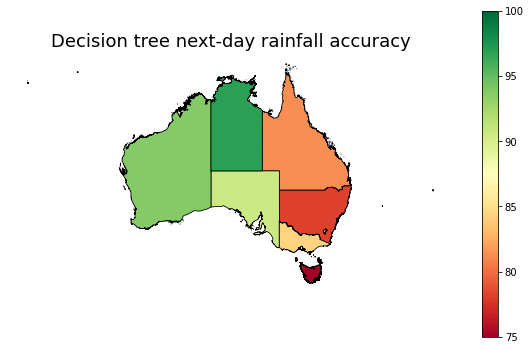

In [35]:
# set up the map figure
fig, ax = plt.subplots(1, figsize=(10, 6));

# set the title
ax.set_title("Decision tree next-day rainfall accuracy", fontdict={"fontsize": "18", "fontweight" : "3"})

# plot the accuracy column
Australia.plot(column="Accuracy", linewidth=0.8, ax=ax, edgecolor='0', cmap='RdYlGn');

# set up the color bar
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=75, vmax=100))

# make an empty array for the data range
sm._A = []

# plot the bar
bar = fig.colorbar(sm)

# remove axes from map
ax.axis('off')